# Demo: CMB Systematics Maps Synthesis with the Scattering Covariance 

## Introduction to the `cmbscat` package

`cmbscat` is a pip installable package that can synthesize new map samples (called **emulations**) which are both visually and statistically similar to the ones found in an (eventually) small dataset of simulations. 

You can install it simply doing:
```
pip install cmbscat
```
You can then set generate a new dataset of CMB systematics maps by doing:

```python
from cmbscat import cmbscat_pipe

# Set emulator parameters
params = {
    'NNN'          : 10,             # Number of input reference maps
    'gauss_real'   : True,             # Generate new input data as Gaussian realizations from pixel covariance of original data
    'NGEN'         : 10,               # Batch size for gradient descent
    'n_samples'    : 10,               # Samples in the input dataset
    'nside'        : 16,               # N_side of input maps
    'NORIENT'      : 4,                # Orientations in the SC
    'nstep'        : 50,              # Steps in gradient descent
    'KERNELSZ'     : 3,                # Wavelet kernel size
    'outname'      : 'example',        # Output name
    'outpath'      : './data/',        # Output path
    'data'         : 'variable_gain_sims.npy'  # Input data path
}

# Initialize pipeline...
pipeline = cmbscat_pipe(params)

#...and run! This generates NGEN new maps for each of the n_samples input maps
pipeline.run()
```

## Scope of this notebook
This notebook demonstrates what happens under the hood of the `cmbscat_pipe` class (without using the `run()` method). We explain in detail the various steps in the `cmbscat_pipe` class step-by-step.

We'll initialize parameters, load some example data, run each method, and create plots to visualize the intermediate and final results of the scattering synthesis.

Let's first of all install the `cmbscat` package with pip. This install all the required dependencies, including the `HealpixML` package on which this demo is heavily based.



In [1]:
!pip install cmbscat # comment this if you already installed cmbscat

In [2]:
# ------------------------------------------------------------
# 0) Imports
# ------------------------------------------------------------
import numpy as np
import healpy as hp
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import foscat.alm as foscat_alm
import foscat.Synthesis as synthe
import foscat.scat_cov as sc
from tqdm import tqdm, trange

from cmbscat import cmbscat_pipe

# If your environment might use inline plotting:
%matplotlib inline


## 1) Define Parameters

Below is an example dictionary of parameters. You can tweak them as you want.

We assume that the input data in `data` are N>NNN (T,Q,U) Healpix maps in RING ordering at `nside_in` resolution, saved in a .npy file. These tensor containing the input data will therefore have shape (N, 3, 12*nside_in**2). 

In [3]:
params = {
    'NNN'          : 10,               # number of input reference maps
    'gauss_real'   : True,             # whether to generate PCA-based Gaussian maps
    'gauss_seed'   : 42,               # random seed for the PCA-based maps
    'NGEN'         : 10,               # number of maps in a batch for the gradient descent
    'n_samples'    : 10,               # how many input samples in the input dataset (used to generate them if gauss_real=True)
    'nmask'        : 2,                # number of masks
    'mask'         : None,             # mask file (if None no mask is used during SC calculation)
    'nside'        : 8,               # nside of the maps (original maps gets downgraded if their nside_in > this nside)
    'NORIENT'      : 4,                # number of orientations in the SC
    'cov'          : True,             # if True uses scat_cov
    'no_orient'    : False,            # if True, orientation matrices won't be used
    'nstep'        : 20,              # number of steps in gradient descent
    'KERNELSZ'     : 3,                # wavelet kernel size
    'ave_target'   : False,            # if True => average-target approach
    'outname'      : 'example',        # prefix for output
    'outpath'      : './data/',        # output path (creates the folder if it doesn't exist)
    'data'         : 'variable_gain_sims.npy'  # path to your input .npy file containing the input dataset
}


 Some useful parameters for plotting are defined below:

In [4]:
# Global color limits (adjust if needed)
min_val = -1e-7
max_val =  1e-7

## 2) Initialize the Pipeline

We create an instance of `cmbscat_pipe` with the above parameters.


In [5]:
pipeline = cmbscat_pipe(params)

[INIT] CMBSCAT with nside=8, scat cov=True, no_orient=False


## 3) Preprocess Data

We call `preprocess_data()` to:
1. Load the data (assumed shape \[N, 3 (T,Q,U), 12*nside_in^2\]) from `params["data"]`.
2. Extract only the first NNN Q,U maps => shape \[NNN, 2, 12*nside_in^2\]. 
3. Downgrade to `nside` (if needed) and reorder to NEST scheme.

The whole pipeline can be easily extended to account also for (T,Q,U) and not just (Q,U). 
Reordering is necessary as HealpixML assumes the input is in NEST ordering.

Let's then visualize the first preprocessed map in Q and U channels.


[PREPROCESS] Loading data from: /Users/pcampeti/FOSCAT_DEMO/dipole_fg_leakage_sims/maps_variable_gain.npy


[PREPROCESS] Downgrading and reordering data to NEST: 100%|██████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 135.37it/s]


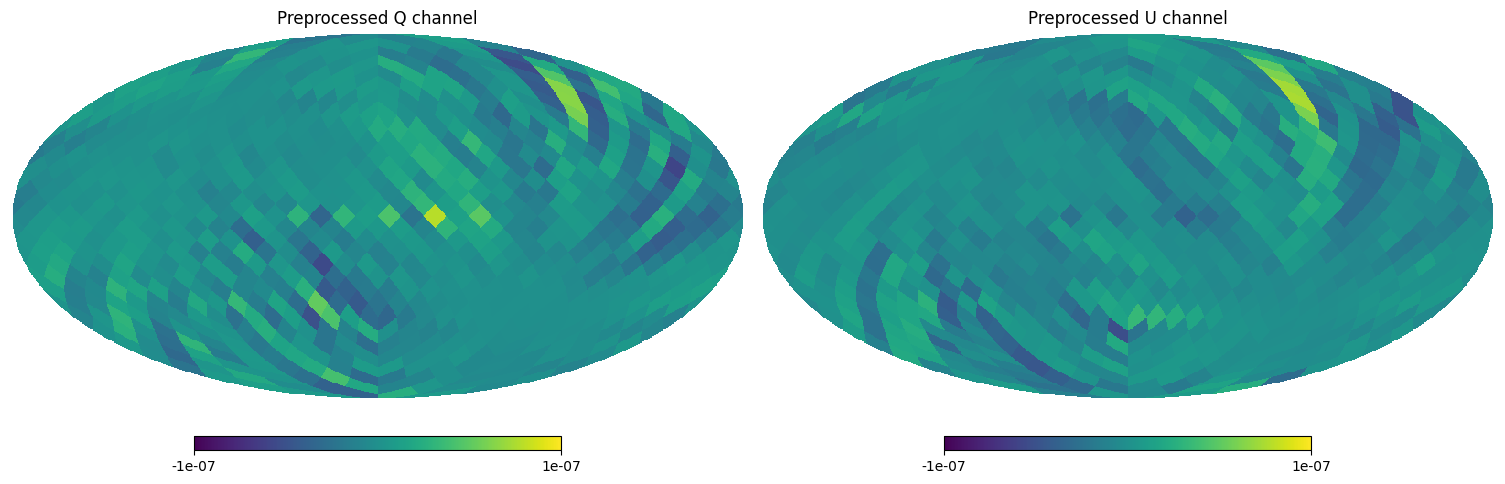

Shape of preprocessed data: (10, 2, 768)


In [6]:
# Run step 1: Preprocessing
pipeline.preprocess_data()

# Access the internal .im array after preprocessing
preprocessed_im = pipeline.im  # shape: (NNN, 2, 12*nside^2)

# Let's plot the first map's Q channel with healpy
idx_map = 0

# Create a figure with a specified size
fig = plt.figure(figsize=(15, 7))

# Plot the Q channel in the first subplot (1 row, 2 columns, first plot)
hp.mollview(preprocessed_im[idx_map, 0], nest=True, min=min_val, max=max_val,
            title='Preprocessed Q channel', sub=(1, 2, 1))

# Plot the U channel in the second subplot (1 row, 2 columns, second plot)
hp.mollview(preprocessed_im[idx_map, 1], nest=True, min=min_val, max=max_val,
            title='Preprocessed U channel', sub=(1, 2, 2))

plt.show()

print(f"Shape of preprocessed data: {preprocessed_im.shape}")

## 4) (Optional) Generate new set of input Gaussian Map Realizations from the pixel covariance of the original maps

If `gauss_real=True`, this step will compute an SVD of the reference dataset and then generate `n_samples` random Gaussian maps. It overwrites `self.im`.


[GAUSS] Performing SVD to generate random Gaussian realizations.
[GAUSS] Generated 10 random Gaussian maps.


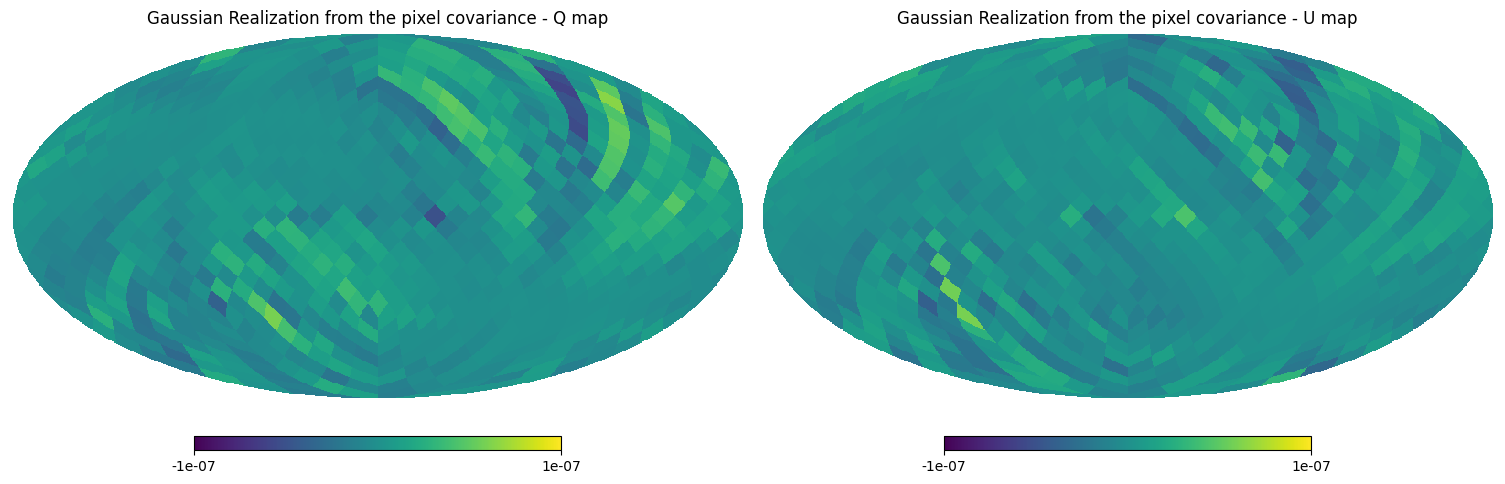

In [7]:
if pipeline.gauss_real:
    pipeline.generate_gaussian_maps()
    # Let's visualize again the first newly generated map
    new_im = pipeline.im
    
    # Create a figure with a specified size
    fig = plt.figure(figsize=(15, 7))

    # Plot the Q channel in the first subplot (1 row, 2 columns, first plot)
    hp.mollview(new_im[0, 0], nest=True, min=min_val, max=max_val, 
                title='Gaussian Realization from the pixel covariance - Q map', sub=(1, 2, 1))

    # Plot the U channel in the second subplot (1 row, 2 columns, second plot)
    hp.mollview(new_im[0, 1], nest=True, min=min_val, max=max_val, 
                title='Gaussian Realization from the pixel covariance - U map', sub=(1, 2, 2))
    plt.show()

## 5) Initialize the Scattering Operator 
We now build the scattering operator (scattering covariance or wavelet scattering transform, depending on if `self.cov` is True).

This is performed using the HealpixML code.

In [8]:
pipeline.init_scat_op()

[INIT_SCAT] Initializing scattering operator.


## 6) Compute Reference Power Spectra

The method `init_reference_ps()` loops over each map in the dataset and computes its angular power spectra (`L_1` and `L_2`) using the built-in `anafast` implementation in tensorfow from `foscat.alm` that can be integrated into gradient computations.

Let's compute and then print shapes of the stored power spectra arrays.


[INIT_REF_PS] Computing angular power spectra of input maps.: 100%|███████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.80it/s]

Shapes of power spectra arrays:
c_l1: (10, 3, 24)
c_l2: (10, 3, 24)


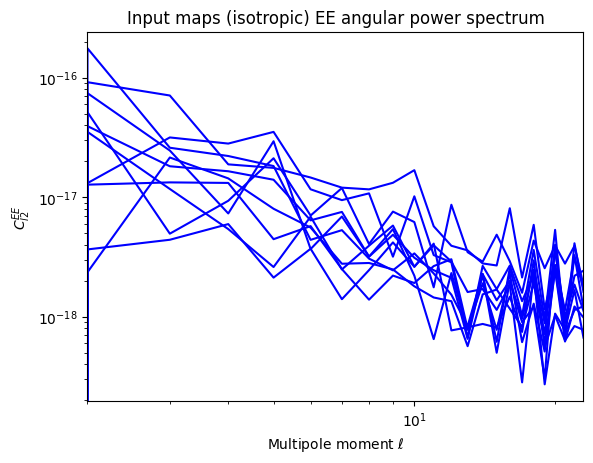

In [9]:
pipeline.init_reference_ps()

print("Shapes of power spectra arrays:")
print(f"c_l1: {pipeline.c_l1.shape}")
print(f"c_l2: {pipeline.c_l2.shape}")

# Plot the input map's L2 isotropic angular power spectrum.
# c_l2 has shape (n_samples, 3, 3*nside)
# The second axis is for [EE, EB, BB]. 

ell = np.arange(3 * pipeline.nside)

fig = plt.figure()
for i in range(pipeline.n_samples):
    plt.plot(ell, pipeline.c_l2[i, 0, :], color='blue') 
plt.title("Input maps (isotropic) EE angular power spectrum")
plt.xlabel("Multipole moment $\ell$")
plt.ylabel("$C_{l2}^{EE}$")
plt.loglog()
plt.xlim(2,ell.max())
plt.show()

## 7) Normalize Data

`normalize_data()` will compute mean and std over the entire dataset (channel-wise, pixel-wise) and normalize the internal data. This is for convention **after** we compute the reference power spectra on the unnormalized maps.

We visualize again the normalized maps.

In [10]:
pipeline.normalize_data()

print("[INFO] Data has been normalized. Mean and std stored in `pipeline.mdim` and `pipeline.dim`.")

[NORMALIZE] Data has been normalized (channel-wise mean/std).
[INFO] Data has been normalized. Mean and std stored in `pipeline.mdim` and `pipeline.dim`.


## 8) Initialize Orientation Matrices

If `no_orient=False`, we compute the orientation matrices. 

In principle, the SC model is designed for homogeneous fields. In our inhomogeneous scenario, additional information to catch the localized structures at large scales is required, which we find particularly efficient to supply by introducing **orientation-informed wavelets**: we define the SC statistics relative to some primary local orientation (in our case relative to the scanning strategy stripes), which is the orientation with the largest amplitude at each pixel and scale in the wavelet-convolved maps. This allows to precompute a $4\times 4$ (in our case with 4 orientations) rotation matrix for each pixel, which rotates the phase of wavelet-convolved maps (before taking the modulus). The SC statistics computed after this rotation will have amplitudes reflecting the alignment with the primary orientation. We describe in more detail the orientation-informed wavelets in Appendix A of Campeti et al 2025.

This is performed using the HealpixML code.

In [11]:
pipeline.init_orient_mat()

# If orientation is used, we have cmat1, cmat12, ...
# Just check if they exist:
print("Orientation matrices shapes (if not None):")

[INIT_ORIENT] Computing orientation matrices cmat1, cmat12, etc.
Orientation matrices shapes (if not None):


## 9) Compute Reference Scattering Coefficients

For each map in `self.im`, the method `init_reference_scat()` computes the scattering coefficients (single-pol Q, single-pol U, and cross (Q,U)).


In [12]:
pipeline.init_reference_scat()

# The dictionaries ref1, ref2, refx hold scattering coefficients for each map
# e.g. pipeline.ref1[0], pipeline.ref2[0], pipeline.refx[0]
print("Keys in ref1, one for each of the input maps:", pipeline.ref1.keys())

[INIT_REF_SCAT] Computing reference scattering of input maps.: 100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.69it/s]

Keys in ref1, one for each of the input maps: dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


## 10) Run the Synthesis

Finally, we call `loop_synthesis()`. This will:
1. Create a new `Synthesis` object that combines the scattering & power spectrum losses.
2. Initialize a batch of random maps to random Gaussian white noise 
3. Perform the mean-field gradient descent simultaneously on a batch of NGEN=10 maps, computing at each step the 4 losses defined in `cmbscat_pipe`. 
4. Save the results to `.npy` files (according to the specified output names/paths).

Because we set `NGEN=10`, we will generate a batch of 10 output synthesized maps per reference target. 

**Note**: For demonstration, we only run for `nstep=50`. This is typically too few steps for a real synthesis, but it’s enough to see the procedure in action.

**Note**: Gradient is typically much faster when run on a GPU! The process is also quite memory intensive so if you're running on your laptop it may be necessary to reduce the `nside` depending on your available RAM.

In [13]:
pipeline.loop_synthesis()

[LOOP_SYNTHESIS] Using single-target


[LOOP_SYNTHESIS] Synthesis over targets:   0%|                                                                                 | 0/10 [00:00<?, ?it/s]

[LOOP_SYNTHESIS] Random seed for batch initialization  0
[LOOP_SYNTHESIS] Displaying simultaneous batch loss minimization for target  0
Total number of loss  4
 Run [PROC=0000] on GPU CPU:0
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
 Run [PROC=0000] on GPU CPU:0
 Run [PROC=0000] on GPU CPU:0
 Run [PR

[LOOP_SYNTHESIS] Synthesis over targets:  10%|███████▎                                                                 | 1/10 [00:56<08:27, 56.37s/it]

Final Loss  15.038224220275879
[LOOP_SYNTHESIS] Random seed for batch initialization  1
[LOOP_SYNTHESIS] Displaying simultaneous batch loss minimization for target  1
Total number of loss  4
 Run [PROC=0000] on GPU CPU:0
 Run [PROC=0000] on GPU CPU:0
 Run [PROC=0000] on GPU CPU:0
 Run [PROC=0000] on GPU CPU:0
Itt      0 L=       244 (       188        191        128        467 ) 42.084s 
Itt     10 L=      18.4 (        22       15.4         26         10 ) 1.177s 
Itt     20 L=       8.4 (      10.7       7.75       12.7       2.43 ) 0.956s 


[LOOP_SYNTHESIS] Synthesis over targets:  20%|██████████████▌                                                          | 2/10 [01:40<06:33, 49.22s/it]

Final Loss  8.397933959960938
[LOOP_SYNTHESIS] Random seed for batch initialization  2
[LOOP_SYNTHESIS] Displaying simultaneous batch loss minimization for target  2
Total number of loss  4
 Run [PROC=0000] on GPU CPU:0
 Run [PROC=0000] on GPU CPU:0
 Run [PROC=0000] on GPU CPU:0
 Run [PROC=0000] on GPU CPU:0
Itt      0 L=       172 (       160        146       88.1        293 ) 41.971s 
Itt     10 L=      12.8 (      14.2       14.7       19.2       3.21 ) 1.136s 
Itt     20 L=      5.31 (      6.81       6.14       6.81       1.46 ) 1.146s 


[LOOP_SYNTHESIS] Synthesis over targets:  30%|█████████████████████▉                                                   | 3/10 [02:24<05:28, 46.96s/it]

Final Loss  5.306870937347412
[LOOP_SYNTHESIS] Random seed for batch initialization  3
[LOOP_SYNTHESIS] Displaying simultaneous batch loss minimization for target  3
Total number of loss  4
 Run [PROC=0000] on GPU CPU:0
 Run [PROC=0000] on GPU CPU:0
 Run [PROC=0000] on GPU CPU:0
 Run [PROC=0000] on GPU CPU:0
Itt      0 L=       493 (       555        344        389        684 ) 41.106s 
Itt     10 L=      48.7 (        60         41       70.9       22.9 ) 1.241s 
Itt     20 L=        19 (      24.6       18.7       28.1       4.69 ) 0.954s 


[LOOP_SYNTHESIS] Synthesis over targets:  40%|█████████████████████████████▏                                           | 4/10 [03:08<04:33, 45.52s/it]

Final Loss  18.997581481933594
[LOOP_SYNTHESIS] Random seed for batch initialization  4
[LOOP_SYNTHESIS] Displaying simultaneous batch loss minimization for target  4
Total number of loss  4
 Run [PROC=0000] on GPU CPU:0
 Run [PROC=0000] on GPU CPU:0
 Run [PROC=0000] on GPU CPU:0
 Run [PROC=0000] on GPU CPU:0
Itt      0 L=      51.8 (      45.1       25.8       22.7        113 ) 41.129s 
Itt     10 L=       3.1 (      3.51        2.9       4.51       1.47 ) 1.109s 
Itt     20 L=      1.24 (      1.53        1.4       1.78      0.263 ) 0.974s 


[LOOP_SYNTHESIS] Synthesis over targets:  50%|████████████████████████████████████▌                                    | 5/10 [03:51<03:43, 44.69s/it]

Final Loss  1.2436211109161377
[LOOP_SYNTHESIS] Random seed for batch initialization  5
[LOOP_SYNTHESIS] Displaying simultaneous batch loss minimization for target  5
Total number of loss  4
 Run [PROC=0000] on GPU CPU:0
 Run [PROC=0000] on GPU CPU:0
 Run [PROC=0000] on GPU CPU:0
 Run [PROC=0000] on GPU CPU:0
Itt      0 L=       247 (       184        208        113        484 ) 41.688s 
Itt     10 L=      18.3 (      14.9       21.7       31.1       5.58 ) 1.051s 
Itt     20 L=      9.25 (       8.6       11.2       15.8       1.41 ) 0.888s 


[LOOP_SYNTHESIS] Synthesis over targets:  60%|███████████████████████████████████████████▊                             | 6/10 [04:35<02:57, 44.33s/it]

Final Loss  9.246965408325195
[LOOP_SYNTHESIS] Random seed for batch initialization  6
[LOOP_SYNTHESIS] Displaying simultaneous batch loss minimization for target  6
Total number of loss  4
 Run [PROC=0000] on GPU CPU:0
 Run [PROC=0000] on GPU CPU:0
 Run [PROC=0000] on GPU CPU:0
 Run [PROC=0000] on GPU CPU:0
Itt      0 L=       406 (       331        452        192        650 ) 41.029s 
Itt     10 L=      30.6 (      27.1       36.5       44.3       14.7 ) 1.025s 
Itt     20 L=      12.9 (      13.9         16       19.8       2.02 ) 0.881s 


[LOOP_SYNTHESIS] Synthesis over targets:  70%|███████████████████████████████████████████████████                      | 7/10 [05:17<02:11, 43.87s/it]

Final Loss  12.921777725219727
[LOOP_SYNTHESIS] Random seed for batch initialization  7
[LOOP_SYNTHESIS] Displaying simultaneous batch loss minimization for target  7
Total number of loss  4
 Run [PROC=0000] on GPU CPU:0
 Run [PROC=0000] on GPU CPU:0
 Run [PROC=0000] on GPU CPU:0
 Run [PROC=0000] on GPU CPU:0
Itt      0 L=       478 (       378        458        318        760 ) 40.534s 
Itt     10 L=      38.3 (      39.4       44.7       54.9       14.2 ) 1.074s 
Itt     20 L=      15.4 (      17.1       19.7       21.9       2.76 ) 0.942s 


[LOOP_SYNTHESIS] Synthesis over targets:  80%|██████████████████████████████████████████████████████████▍              | 8/10 [06:00<01:26, 43.45s/it]

Final Loss  15.370977401733398
[LOOP_SYNTHESIS] Random seed for batch initialization  8
[LOOP_SYNTHESIS] Displaying simultaneous batch loss minimization for target  8
Total number of loss  4
 Run [PROC=0000] on GPU CPU:0
 Run [PROC=0000] on GPU CPU:0
 Run [PROC=0000] on GPU CPU:0
 Run [PROC=0000] on GPU CPU:0
Itt      0 L=       115 (       107       79.2       53.8        221 ) 41.535s 
Itt     10 L=      8.55 (      8.11       9.89       13.5        2.7 ) 1.123s 
Itt     20 L=      4.13 (      4.18       5.25       6.35      0.747 ) 1.043s 


[LOOP_SYNTHESIS] Synthesis over targets:  90%|█████████████████████████████████████████████████████████████████▋       | 9/10 [06:44<00:43, 43.53s/it]

Final Loss  4.129349231719971
[LOOP_SYNTHESIS] Random seed for batch initialization  9
[LOOP_SYNTHESIS] Displaying simultaneous batch loss minimization for target  9
Total number of loss  4
 Run [PROC=0000] on GPU CPU:0
 Run [PROC=0000] on GPU CPU:0
 Run [PROC=0000] on GPU CPU:0
 Run [PROC=0000] on GPU CPU:0
Itt      0 L=      62.7 (      45.9       46.4       30.6        128 ) 41.035s 
Itt     10 L=      4.53 (      5.42       5.44       5.52       1.73 ) 1.103s 
Itt     20 L=      1.64 (      2.31       1.84       1.96      0.459 ) 1.027s 


[LOOP_SYNTHESIS] Synthesis over targets: 100%|████████████████████████████████████████████████████████████████████████| 10/10 [07:27<00:00, 44.74s/it]

Final Loss  1.6411958932876587
[LOOP_SYNTHESIS] Loss minimization completed.


## 11) Visualize Initial Maps and Final Synthesis Output

First we visualize a sample from the initial white noise realizations used to initialize the gradient descent 

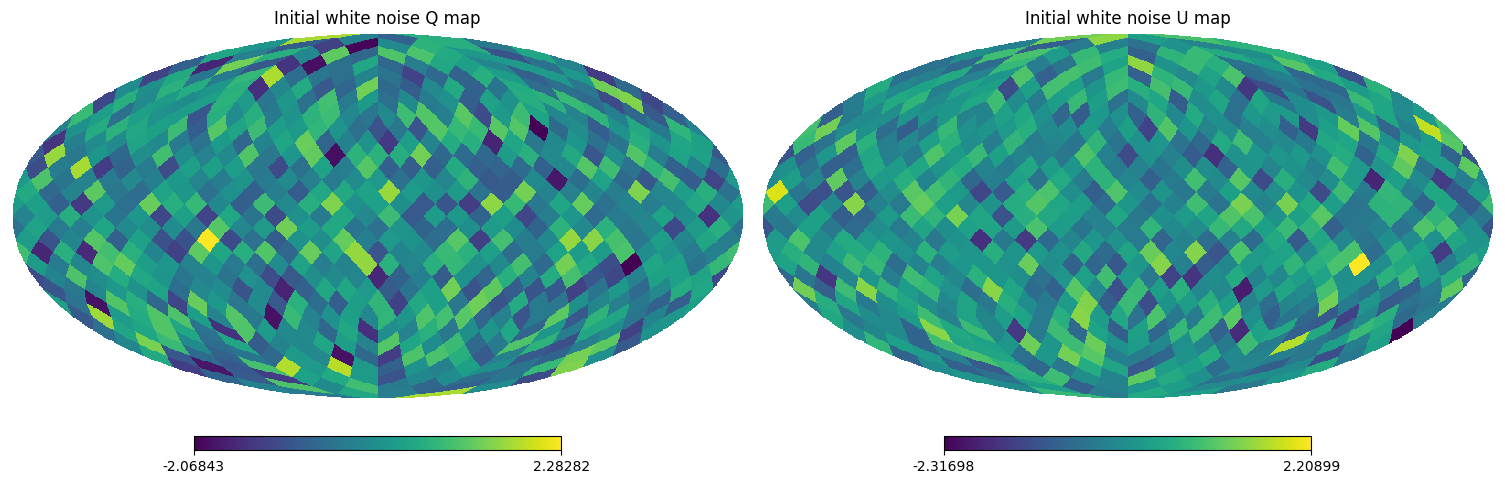

In [25]:
fig = plt.figure(figsize=(15, 7))
# Plot the Q channel in the first subplot (1 row, 2 columns, first plot)
hp.mollview(pipeline.imap[0, 0], nest=True, title='Initial white noise Q map', sub=(1, 2, 1))
# Plot the U channel in the second subplot (1 row, 2 columns, second plot)
hp.mollview(pipeline.imap[0, 1], nest=True, title='Initial white noise U map', sub=(1, 2, 2))
plt.show()

After `loop_synthesis()` completes, the pipeline saves results in `.npy` files at `outpath`. 

In a real scenario, you’d load them back or directly capture the final arrays. Because in the code above, it saves the final arrays as `out_XXX_map_16.npy`, we can do something like:


Loaded synthesized output shape: (10, 2, 768)


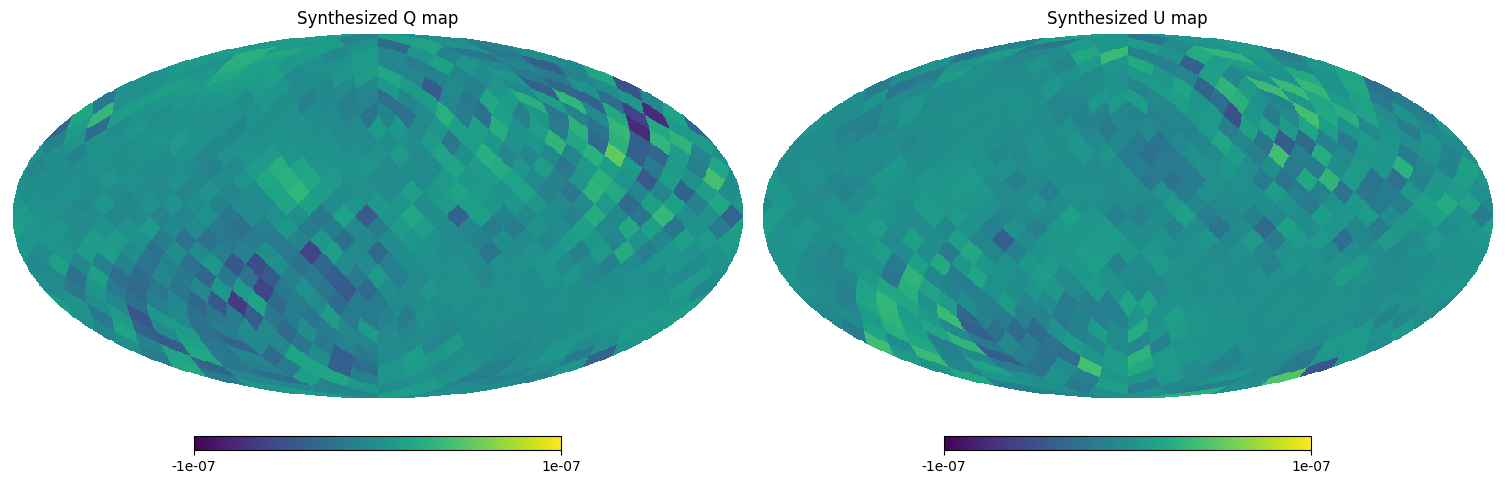

In [15]:
# Suppose in your loop_synthesis you keep them in a variable or you just re-load them here
# For demonstration, let's pretend we re-load them:

# these are the maps in the first batch corresponding to target 0
out_data = np.load(pipeline.outpath+'out_'+pipeline.outname+'_000_map_'+str(pipeline.nside)+'.npy')
print(f"Loaded synthesized output shape: {out_data.shape}")

fig = plt.figure(figsize=(15, 7))
# Plot the Q channel in the first subplot (1 row, 2 columns, first plot)
hp.mollview(out_data[0, 0], nest=True, min=min_val, max=max_val, title='Synthesized Q map', sub=(1, 2, 1))
# Plot the U channel in the second subplot (1 row, 2 columns, second plot)
hp.mollview(out_data[0, 1], nest=True, min=min_val, max=max_val, title='Synthesized U map', sub=(1, 2, 2))
plt.show()

## 12) Quick visual validation: compare emulated with input maps

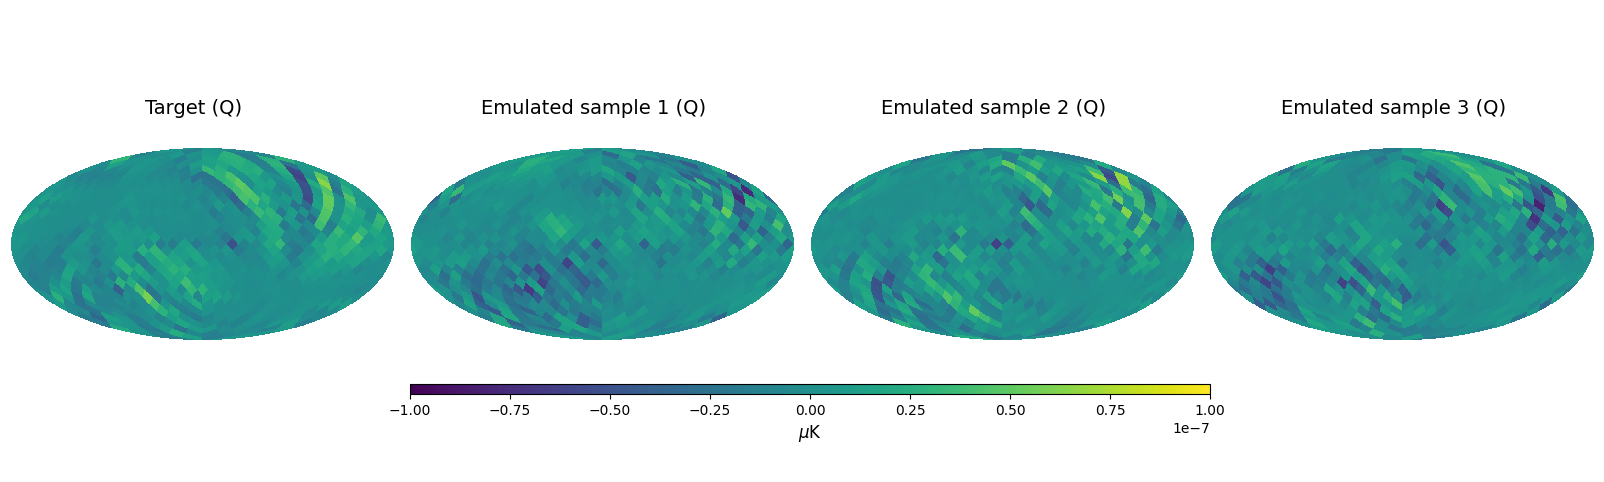

In [16]:
n_targets = 1    # number of target plotted 
n_emulated = 3    # Number of generated maps to display per target
ncols = 1 + n_emulated  # 1 target column + 3 emulated columns
nrows = n_targets
cmap = 'viridis'

# ============================================================================
# PLOTTING
# ============================================================================
# We plot only the Q component (index 0) for each map.
fig, axes = plt.subplots(
    nrows=nrows, ncols=ncols,
    figsize=(16, 6),
    gridspec_kw={'wspace': 0.05, 'hspace': 0.17}
)

column_titles = ["Target (Q)", "Emulated sample 1 (Q)", "Emulated sample 2 (Q)", "Emulated sample 3 (Q)"]

for i in range(nrows):
    maps_to_plot = [new_im[i][0]] + [emap[0] for emap in out_data]
    
    for j in range(ncols):
        ax = axes[i, j] if nrows > 1 else axes[j]
        plt.sca(ax)
        
        hp.mollview(
            maps_to_plot[j],
            fig=fig.number,
            sub=(nrows, ncols, i*ncols + j + 1),
            title="",  
            min=min_val,
            max=max_val,
            cbar=False,
            notext=True,
            cmap=cmap,
            nest=True,
        )
        ax.axis('off')

x_positions = np.linspace(0.125, 0.875, ncols)  
for j in range(ncols):
    fig.text(x_positions[j], 0.7, column_titles[j],
             ha='center', va='bottom', fontsize=14, color='black')

dummy_mappable = plt.cm.ScalarMappable(
    norm=plt.Normalize(vmin=min_val, vmax=max_val),
    cmap=cmap
)
dummy_mappable.set_array([])
cbar_ax = fig.add_axes([0.26, 0.24, 0.5, 0.016])
cbar = plt.colorbar(dummy_mappable, cax=cbar_ax, orientation='horizontal')
cbar.set_label(r"$\mu$K", fontsize=12)

## 13) Quick Validation: Angular Power Spectra

Here we use `healpy` `anafast` routine to compute the angular power spectra of the target input map and compare it to the average of the batch of maps emulated using it as target.

Before computing spectra we need to convert the maps back to RING order.

In [17]:
lmax = 3*pipeline.nside # max multipole in the spectra

# dummy T map just to compute the power spectra with anafast
npix = hp.nside2npix(pipeline.nside)
T_map = np.random.randn(npix)

# compute spectra of synthesized maps with anafast
ps_out = np.zeros((out_data.shape[0], 2, lmax))
for k in range(0, out_data.shape[0]):
    Q_map = hp.reorder(out_data[k, 0], n2r=True)
    U_map = hp.reorder(out_data[k, 1], n2r=True)

    input_maps = np.array([T_map, Q_map, U_map])
    _, EE, BB, _, _, _ = hp.anafast(input_maps)
    ps_out[k, 0] = EE
    ps_out[k, 1] = BB

# compute spectra of input maps (unnnormalized) with anafast
ps_in = np.zeros((new_im.shape[0], 2, lmax))
for k in range(0, new_im.shape[0]):
    Q_map = hp.reorder(new_im[k, 0], n2r=True)
    U_map = hp.reorder(new_im[k, 1], n2r=True)

    input_maps = np.array([T_map, Q_map, U_map])
    _, EE, BB, _, _, _ = hp.anafast(input_maps)
    ps_in[k, 0] = EE
    ps_in[k, 1] = BB

# compute mean of the input dataset spectra
mean_ps_in = np.mean(ps_in, axis=0)

# compute mean of the emulated dataset spectra
mean_ps_out = np.mean(ps_out, axis=0)

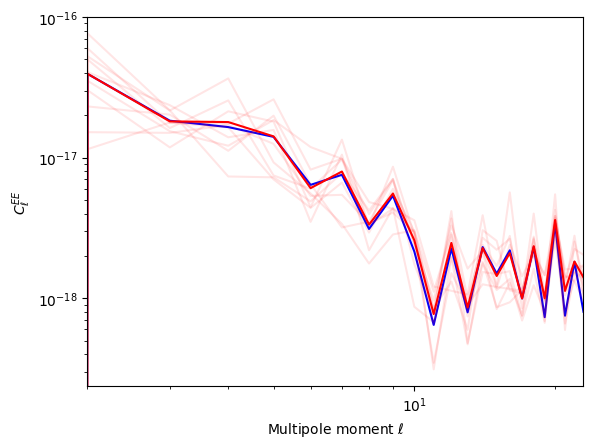

In [18]:
# let's plot the EE spectra of the emulated maps in the first batch and compare to the first target in the input maps
# we compare also the mean over the batch with the target
fig = plt.figure()
plt.plot(ell, ps_in[0,0], color='blue', label = 'Mean Input')
for i in range(pipeline.NGEN):
    plt.plot(ell, ps_out[i,0], color='red', alpha=0.1) 
# we compare also the mean over the batch with the target
plt.plot(ell, mean_ps_out[0], color='red', label = 'Mean Emulated') 
plt.xlabel("Multipole moment $\ell$")
plt.ylabel("$C_{\ell}^{EE}$")
plt.loglog()
plt.xlim(2,ell.max())
plt.show()

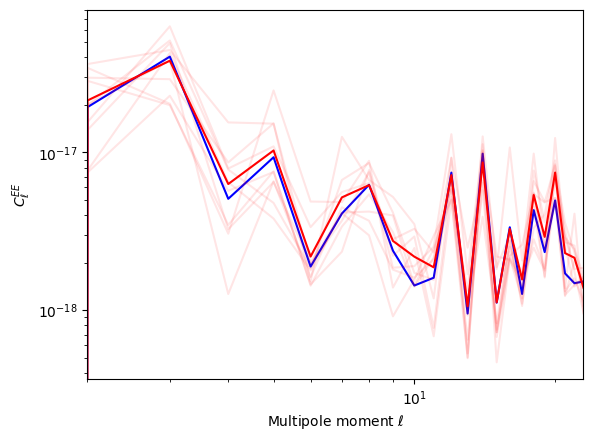

In [19]:
# let's plot the BB spectra of the emulated maps in the first batch and compare to the first target in the input maps
# we compare also the mean over the batch with the target
fig = plt.figure()
plt.plot(ell, ps_in[0,1], color='blue', label = 'Mean Input')
for i in range(pipeline.NGEN):
    plt.plot(ell, ps_out[i,1], color='red', alpha=0.1) 
# we compare also the mean over the batch with the target
plt.plot(ell, mean_ps_out[1], color='red', label = 'Mean Emulated') 
plt.xlabel("Multipole moment $\ell$")
plt.ylabel("$C_{\ell}^{EE}$")
plt.loglog()
plt.xlim(2,ell.max())
plt.show()

## 14) Quick validation: SC coefficients 
Let's now quickly plot the SC coefficients of the emulated maps.

For this we exploit again the routines in `HealpiML` to quickly compute the SC coefficients of the of the 1st input Q map and of the emulated batch maps: 

In [20]:
ref = pipeline.scat_op.eval(new_im[0,0], norm='self', cmat=pipeline.cmat1, cmat2=pipeline.cmat12)
print(ref)

The the ones of all the emulated Q maps in the batch of `NGEN` maps and their mean:  

In [21]:
synth = {}
for k in range(pipeline.NGEN):
    synth[k] = pipeline.scat_op.eval(out_data[k, 0], norm='self', cmat=pipeline.cmat1, cmat2=pipeline.cmat12)

# let's compute also the mean SC coefficients of the NGEN emulated maps in the batch
msynth, vsynth = pipeline.scat_op.moments(synth)

Now we quickly plot them using the plotting routines also in `HealpixML`:

/Users/pcampeti/anaconda3/envs/myenv/lib/python3.11/site-packages/foscat/scat_cov.py:1357: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(frameon=0)
/Users/pcampeti/anaconda3/envs/myenv/lib/python3.11/site-packages/foscat/scat_cov.py:1525: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(frameon=0)
/Users/pcampeti/anaconda3/envs/myenv/lib/python3.11/site-packages/foscat/scat_cov.py:1357: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(frameon=0)
/Users/pcampeti/anaconda3/envs/myenv/lib/python3.11/site-packages/foscat/scat_cov.py:1525: UserWarning: No artists with labels found to put in le

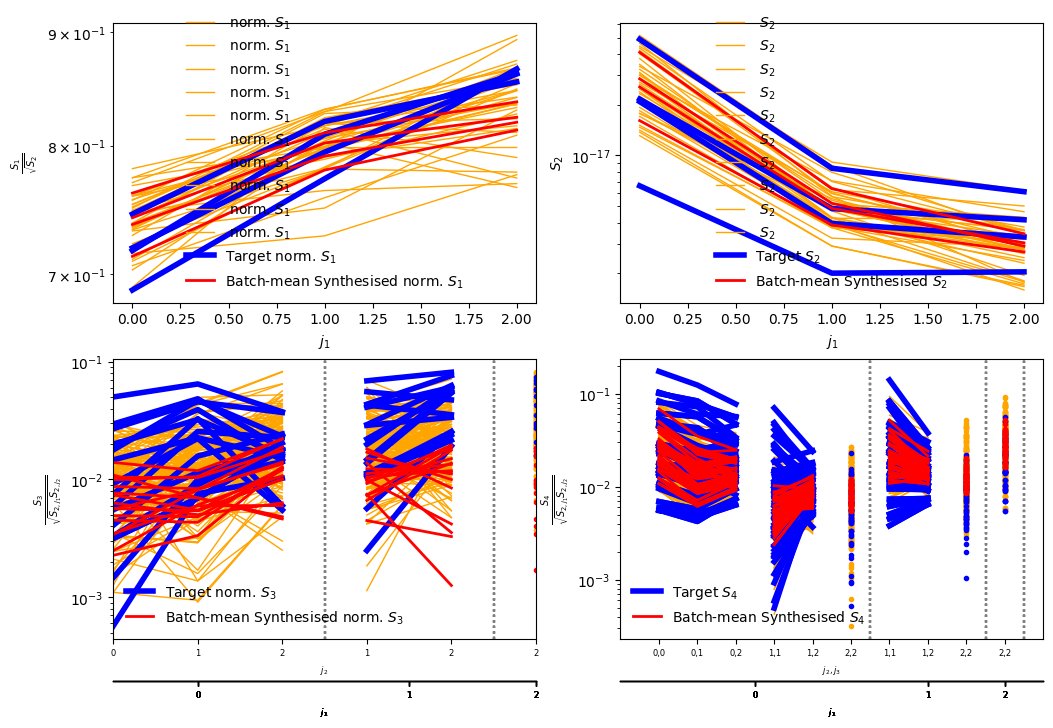

In [26]:
plt.figure(figsize=(12,8))

# let's plot the SC coefficients of the emulated maps in the batch
for k in range(pipeline.NGEN):
    synth[k].plot(name=None, color='orange', hold=False, norm=True, legend=False)

# let's plot the SC coefficients of the target 
ref.plot(name='Target',color='blue',norm=True,lw=4,hold=False)

# let's plot the mean SC coefficients of the NGEN emulated maps in the batch
msynth.plot(name='Batch-mean Synthesised', color='red', hold=False, norm=True, lw=2)

We plot also in solid orange the SC coeff of all the emulated maps in the batch.

In particular we would like the mean over the whole batch of the SC coefficients (solid red) to follow closely to SC coefficients of the input map used as a target for that batch (solid blue). 

This typically requires few hundreds (or sometimes 1000 or more) steps in gradient descent, depending on the specific case. Since in this demo we ran gradient descent only for 50 steps we do not expect them to coincide yet. 

You can try to run for more steps and see them gradually approaching the target in batch mean. 

  

# Conclusion

We have demonstrated each step of the `cmbscat_pipe` workflow with separate cells and some minimal visualization:
1. **Define Parameters**
2. **Initialize Pipeline** 
3. **Preprocessing** input maps
4. **(Optional) Gaussian** generation from the pixel covariance of the original dataset
5. **Scattering Operator** initialization
6. **Reference Power Spectra** computation
7. **Normalization**
8. **Orientation Matrices** initialization
9. **Reference Scattering Coefficients** computation
10. **Synthesis** loop
11. **Visualize Synthesis Output**
12. **Quick visual validation: compare emulated with input maps**
13. **Quick Validation: Angular Power Spectra**
14. **Quick validation: SC coefficients**
15. **Final Output** visualization
